In [1]:
import pandas as pd
import numpy as np

import os

from PIL import Image
from PIL import UnidentifiedImageError

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
parasitized = os.listdir('C:\\Users\\Arif\\cell_images\\Parasitized\\')
uninfected = os.listdir('C:\\Users\\Arif\\cell_images\\Uninfected\\')

In [3]:
img_w, img_h = 64, 64
X = []
y = []

In [4]:
for i in uninfected:
    try:
        img = Image.open("C:\\Users\\Arif\\cell_images\\Uninfected\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass

In [5]:
for i in parasitized:
    try:
        img = Image.open("C:\\Users\\Arif\\cell_images\\Parasitized\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [6]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

(27558, 64, 64, 3) (27558,)


In [7]:
x = X.astype('float32')
x /= 255

In [8]:
num_classes = 2

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[1. 0.]


In [9]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, labels, test_size = 0.1, random_state=5)
print('Train dataset number: {}'.format(len(x_train)))
print('Test dataset number: {}'.format(len(x_val)))

Train dataset number: 24802
Test dataset number: 2756


In [10]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=[img_w, img_h] + [3])

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(150, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
epochs = 20

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(
        x_train, y_train,
        steps_per_epoch= len(x_train)/16,
        epochs = epochs,
        callbacks = callbacks_list,
        validation_data= (x_val, y_val), 
        verbose = 1)

Epoch 1/20
1550/1550 [============================>.] - ETA: 0s - loss: 0.2533 - accuracy: 0.8979
Epoch 1: val_loss improved from inf to 0.19308, saving model to model.h5
1550/1550 [==============================] - 289s 186ms/step - loss: 0.2533 - accuracy: 0.8980 - val_loss: 0.1931 - val_accuracy: 0.9263
Epoch 2/20


C:\Users\Nayee\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1550/1550 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9191
Epoch 2: val_loss improved from 0.19308 to 0.18277, saving model to model.h5
1550/1550 [==============================] - 210s 135ms/step - loss: 0.2064 - accuracy: 0.9191 - val_loss: 0.1828 - val_accuracy: 0.9300
Epoch 3/20
1550/1550 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9240
Epoch 3: val_loss did not improve from 0.18277
1550/1550 [==============================] - 207s 133ms/step - loss: 0.1918 - accuracy: 0.9240 - val_loss: 0.2235 - val_accuracy: 0.9097
Epoch 4/20
1550/1550 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9304
Epoch 4: val_loss improved from 0.18277 to 0.17383, saving model to model.h5
1550/1550 [==============================] - 211s 136ms/step - loss: 0.1785 - accuracy: 0.9304 - val_loss: 0.1738 - val_accuracy: 0.9347
Epoch 5/20
1550/1550 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9336
Epoch 5

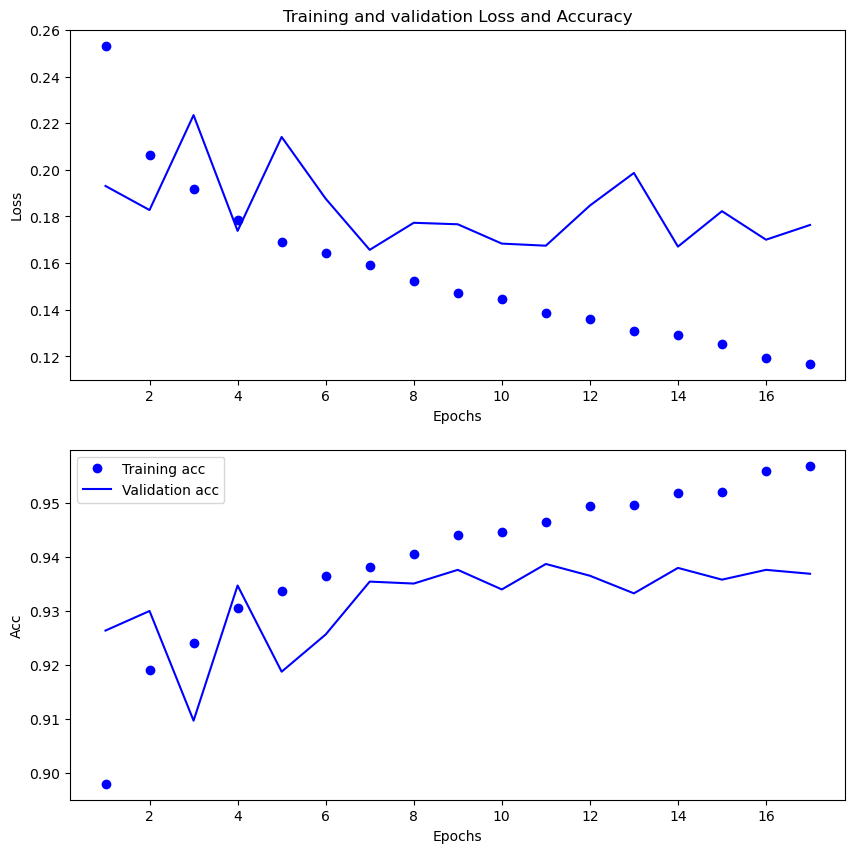

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show() 

In [13]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

In [14]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16569775342941284
Test accuracy: 0.935413658618927


In [15]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

87/87 [==============================] - 20s 232ms/step
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  Uninfected       0.94      0.94      0.94      1420
   Parasited       0.93      0.93      0.93      1336

    accuracy                           0.94      2756
   macro avg       0.94      0.94      0.94      2756
weighted avg       0.94      0.94      0.94      2756



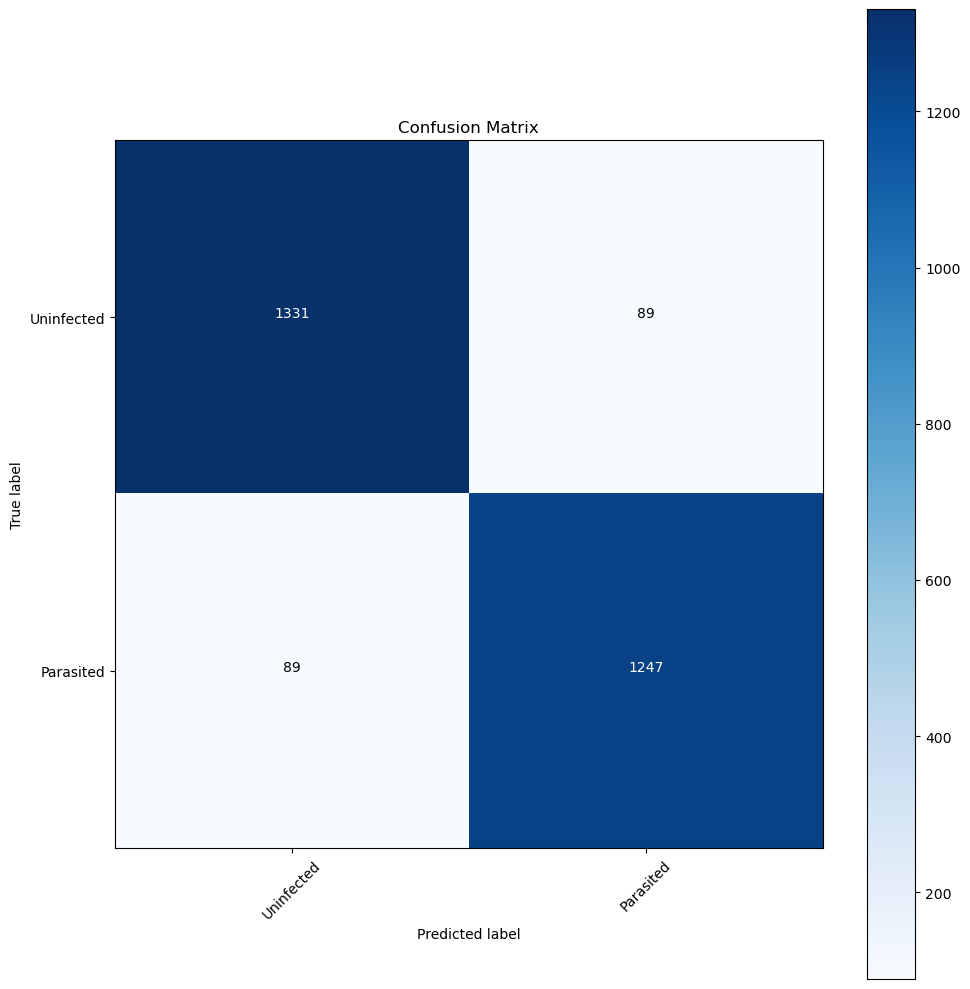

In [16]:
import numpy as np

y_pred = (model.predict(x_val) > 0.5).astype("int32")

y_test_c = np.argmax(y_val, axis=1)
target_names = ["Uninfected", "Parasited"]

Y_pred = np.argmax(model.predict(x_val),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))